In [1]:
## Notebook for extracting pupil data etc

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general imports
import sys
import pickle
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

import popoff
import pop_off_functions as pof
import pop_off_plotting as pop

from Session import Session, SessionLite, build_flu_array_single
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel


/home/tplas/repos/popping-off/popoff/popoff/loadpaths.py
/home/tplas/repos/Vape


In [ ]:
## Load sessions
pas = PoolAcrossSessions(remove_targets=False, subsample_sessions=False,
                         remove_toosoon=True, pre_start=-0.51)

for ss in pas.sessions.values():
    _ = pop.normalise_raster_data(session=ss, sort_neurons=False, filter_150_stim=False)
    

In [4]:
# ## put your path to your vape repo here 
# path_to_vape = os.path.expanduser('~/Documents/code/Vape/')
# popoff_path = '/home/jrowland/Documents/code/pop-off/scripts/'

# # Bit hacky but oh well
# sys.path.append(path_to_vape)
# sys.path.append(os.path.join(path_to_vape, 'utils'))
# sys.path.append(popoff_path)

# from utils.utils_funcs import d_prime

In [161]:
df_pupil_mice = pd.DataFrame({'mouse': ['RL117', 'RL117'], 'run_number': [29, 30],
                              'filename_prefix': ['2021-03-09_RL117', '2021-03-10_RL117']})
df_pupil_mice['signature'] = df_pupil_mice['mouse'] + '_' + df_pupil_mice['run_number'].astype(str)
df_pupil_mice

,mouse,run_number,filename_prefix,signature
0,RL117,29,2021-03-09_RL117,RL117_29
1,RL117,30,2021-03-10_RL117,RL117_30


In [162]:
def load_pupil_data(df_pupil_mice, dir='/home/tplas/data/mice'):
    dict_pupil_data = {signature: {} for signature in df_pupil_mice['signature']}

    for i_sess, signature in enumerate(dict_pupil_data.keys()):
        print(signature)
        basic_filename = os.path.join(dir, df_pupil_mice[df_pupil_mice['signature'] == signature]['filename_prefix'].iloc[0])
        dict_pupil_data[signature]['area_array'] = np.load(basic_filename + '_AreaArray.npy')
        dict_pupil_data[signature]['binary_score'] = np.load(basic_filename + '_BinaryScore.npy')
        dict_pupil_data[signature]['r2_distance'] = np.load(basic_filename + '_r2Distance.npy')
        dict_pupil_data[signature]['area_array_corrected'] = handle_outliers(data_arr=dict_pupil_data[signature]['area_array'],
                                                                            bool_good_dp=dict_pupil_data[signature]['binary_score'])

    return dict_pupil_data



dict_pupil_data[signature]['binary_score'] = np.concatenate((dict_pupil_data[signature]['binary_score'], np.where(np.isnan(dict_pupil_data[signature]['area_array']))[0]))
dict_pupil_data[signature]['binary_score'] = np.sort(np.unique(dict_pupil_data[signature]['binary_score'] ))

def consecutive(data, stepsize=1):
    '''https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-in-a-numpy-array'''
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def handle_outliers(data_arr=None, bool_good_dp=None, bool_bad_dp=None):
    '''bool_good_dp: inds of ones to keep, bad vice versa'''
    data_arr = copy.deepcopy(data_arr)
    if bool_bad_dp is None and bool_good_dp is not None:
        tmp_bool_arr = np.ones(len(data_arr), dtype='bool')
        tmp_bool_arr[bool_good_dp] = False 

        nan_inds = np.where(np.isnan(data_arr))[0]
        tmp_bool_arr[nan_inds] = True
        tmp_bool_arr = np.where(tmp_bool_arr)[0]
        list_of_outlier_intervals = consecutive(tmp_bool_arr)
    elif bool_good_dp is None and bool_bad_dp is not None:
        print('WARNING: no nan correction yet!!')
        list_of_outlier_intervals = consecutive(bool_bad_dp)
    for interval in list_of_outlier_intervals:
        start_dp = interval[0] - 1
        end_dp = interval[-1] + 1
        n_dps = len(interval)

        if end_dp > len(data_arr) - 1:
            print('last ind is outlier')
            # diff_start = np.diff(data_arr[start_dp - 1:start_dp + 1])
            # linear_interpolation = np.linspace(data_arr[start_dp], data_arr[stdict_pupil_data[signature]['area_array']art_dp] + diff_start * n_dps, n_dps + 1)
            # data_arr[start_dp:end_dp] = np.squeeze(linear_interpolation)
            data_arr[start_dp:end_dp] = data_arr[start_dp]

        elif start_dp == -1:
            print('first ind is outlier')
            data_arr[:end_dp] = data_arr[end_dp]

        else:
            linear_interpolation = np.linspace(data_arr[start_dp], data_arr[end_dp], n_dps + 2)
            assert linear_interpolation[0] == data_arr[start_dp], f'{start_dp, end_dp, data_arr[start_dp], data_arr[end_dp], linear_interpolation[0]}'
            assert linear_interpolation[-1] == data_arr[end_dp]
            data_arr[start_dp:end_dp + 1] = linear_interpolation
        
    return data_arr

dict_pupil_data = load_pupil_data(df_pupil_mice=df_pupil_mice)

RL117_29
first ind is outlier
RL117_30


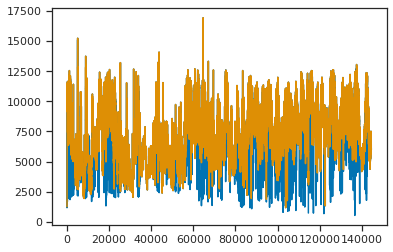

In [163]:

plt.plot(dict_pupil_data['RL117_29']['area_array'])

plt.plot(dict_pupil_data['RL117_29']['area_array_corrected'])


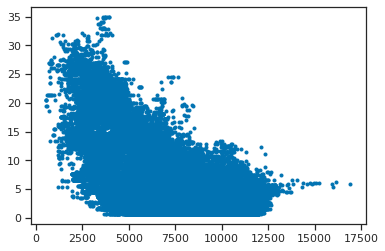

In [164]:
plt.plot(dict_pupil_data['RL117_29']['area_array'], dict_pupil_data['RL117_29']['r2_distance'], '.')

In [165]:
## Load run 
def load_run(mouse, run_number, base_path):
    pkl_path = os.path.join(base_path, mouse, f'run{run_number}.pkl')
    print(pkl_path)
    with open(pkl_path, 'rb') as f:
        run = pickle.load(f)
    
    return run

def get_dict_runs(df_pupil_mice):

    dict_runs = {} 
    for i_sess in range(len(df_pupil_mice)):
        print(df_pupil_mice['signature'].iloc[i_sess])
        dict_runs[df_pupil_mice['signature'].iloc[i_sess]] = load_run(mouse=df_pupil_mice['mouse'].iloc[i_sess],
                                                                      run_number=df_pupil_mice['run_number'].iloc[i_sess],
                                                                      base_path='/home/tplas/data/mice/runs/')
    return dict_runs

dict_runs = get_dict_runs(df_pupil_mice=df_pupil_mice)

RL117_29
/home/tplas/data/mice/runs/RL117/run29.pkl
RL117_30
/home/tplas/data/mice/runs/RL117/run30.pkl


In [166]:
dict_runs['RL117_29'].flu.shape

(507, 130411)

In [167]:
def filter_frames_first_pass(run, pupil):
    idx_imaged = np.isin(run.frame_clock, run.paqio_frames)
    assert sum(idx_imaged) == run.flu.shape[1]
    assert len(idx_imaged) == len(pupil)
    pupil = pupil[idx_imaged]
    return pupil

def find_session_for_pupil(sess_dict, signature='J064_29'):
    mouse = signature.split('_')[0]
    run_number = int(signature.split('_')[1])

    for i_s, sess in sess_dict.items():
        if mouse == sess.mouse and run_number == sess.run_number:
            return sess

    print('NO session found!')


for signature in dict_pupil_data.keys():
    for name_p in ['area_array', 'r2_distance']:
        dict_pupil_data[signature][name_p] = filter_frames_first_pass(run=dict_runs[signature], 
                                                                      pupil=dict_pupil_data[signature][name_p])

In [178]:
## I am James Rowland and this is my invention:

for signature in df_pupil_mice['signature']:
    corresponding_sess = find_session_for_pupil(sess_dict=pas.sessions, signature=signature)
    
    dict_runs[signature].pupil = np.expand_dims(dict_pupil_data[signature]['area_array'], 0)  # add to run so we can use build_flu_array_single 
    dict_pupil_data[signature]['pupil_size'] = np.squeeze(build_flu_array_single(run=dict_runs[signature], use_pupil=True, 
                                                                        pre_frames=60, post_frames=120))
                                                                    #   pre_frames=corresponding_sess.pre_frames, 
                                                                    #   post_frames=corresponding_sess.post_frames))  # use session pre_frames & post_frames here

    dict_pupil_data[signature]['pupil_size'] = dict_pupil_data[signature]['pupil_size'][corresponding_sess.nonnan_trials, :]
    print(f'Loaded pupil with shape (trials x time points) {dict_pupil_data[signature]["pupil_size"].shape}')
    assert np.isnan(dict_pupil_data[signature]['pupil_size']).sum() == 0


Loaded pupil with shape (trials x time points) (260, 180)
Loaded pupil with shape (trials x time points) (192, 180)


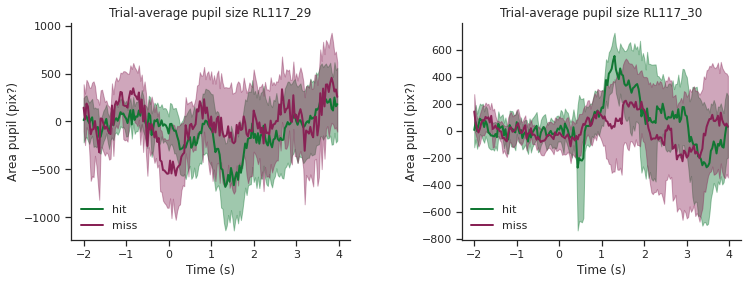

In [179]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.4})
colors = {'hit': '#117733', 'miss': '#882255'}
for iplot, signature in enumerate(['RL117_29', 'RL117_30']):
    curr_ax = ax[iplot]
    pupil_arr = dict_pupil_data[signature]['pupil_size']
    session = find_session_for_pupil(sess_dict=pas.sessions, signature=signature)
    preframes = 60
    time_arr = np.linspace(-2, 4 - 1/30, pupil_arr.shape[1])
    assert len(time_arr) == pupil_arr.shape[1]

    # Baseline the pupil
    baseline = np.mean(pupil_arr[:, :preframes], 1)
    pupil_arr = np.subtract(pupil_arr.T, baseline).T

    for tt in ['hit', 'miss']:
        curr_sel = pupil_arr[session.outcome==tt, :]
        curr_ax.plot(time_arr, curr_sel.mean(0), linewidth=2, color=colors[tt], label=tt)
        ci_95 = curr_sel.std(0) / np.sqrt(curr_sel.shape[0]) * 1.96
        curr_ax.fill_between(x=time_arr, y1=curr_sel.mean(0) - ci_95, 
                             y2=curr_sel.mean(0) + ci_95, color=colors[tt], alpha=0.4)
    
    curr_ax.set_title(f'Trial-average pupil size {signature}')
    curr_ax.set_xlabel('Time (s)')
    curr_ax.set_ylabel('Area pupil (pix?)')
    curr_ax.legend(loc='lower left', frameon=False)
    pop.despine(curr_ax)

In [71]:
# np.diff(session.filter_ps_time)
np.diff(np.linspace(-2, 4 - 1/30, pupil_arr.shape[1]))

array([0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333

In [58]:
pupil_arr = np.subtract(pupil_arr.T, baseline).T
print(pupil_arr.shape)

(192, 180)


## Analysis to do:
- Show dynamics of pupil size on hit vs miss trials (validation that it worked)
- Show histogram of pre-stim pupil size hit vs miss
- Scatter plot pupil size vs pop var (both just pre-stim & full dynamics)
- Optionally, as control, compare pupil size pre-stim vs n_stim 